<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/Benchmark_(MobileNetV3Large).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benchmark CNN Model**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook ใช้สำหรับการ Train CNN Model

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com

## **Section 0: Import important library**

In [1]:
import os
import itertools
import time
from psutil import virtual_memory

import pandas as pd
import numpy as np
import random as rd

import tensorflow as tf
#import tf_keras_vis
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import sklearn

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
import albumentations as A

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


In [5]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Fri Oct 24 15:06:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   40C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Section 1: Preparing the directory for dataset and model**

### **In G-Drive Directory**

In [6]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling.zip"

In [7]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

In [8]:
MODEL_PATH = f"{DRIVE_DIR}/models" # <= สำหรับเก็บ Log Model ต่าง ๆ
MODEL_NAME = "MobileNetV3Large" # <= Model อะไร
OPTIMIZER_NAME = "Adam" # <= Optimizer อะไร
TYPE = "FeatureExtraction" # <= Fine-Tuned หรือ Feature Extraction
ROUND_NUM = 1 # <= รันครั้งที่เท่าไหร่
MODEL_FULL_PATH = f"{MODEL_PATH}/{MODEL_NAME}_{TYPE}_{OPTIMIZER_NAME}_{ROUND_NUM}"
ASSETS_FOR_MODEL_PATH = f"{MODEL_FULL_PATH}/assets" # <= สำหรับเก็บรูปภาพต่าง ๆ จากโมเดล

os.makedirs(MODEL_FULL_PATH, exist_ok=True)
os.makedirs(ASSETS_FOR_MODEL_PATH, exist_ok=True)

In [9]:
MODEL_KERAS_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.keras"
MODEL_H5_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.h5"
MODEL_TFLITE_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.tflite"
MODEL_CHECKPOINT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_best.keras"
MODEL_TENSORBOARD_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_tensorboard.logs"
MODEL_HISTORY_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_history.csv"
MODEL_JSON_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_json.json"
MODEL_REPORT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_report.csv"

### **In Runtime Directory**

In [10]:
!unzip /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling.zip -d /content/ham10000Dataset

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030998_aug_1449.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0029731_aug_490.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0031961.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030812_aug_902.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030369_aug_2134.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0026958_aug_2635.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0032179.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0033709_aug_2407.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030173_aug_2008.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0026844_aug_1881.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030318.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0033322_aug_884.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0025810_

In [11]:
DATASET_DIR = "/content/ham10000Dataset"

## **Section 2: Preprocessing and augmentaion images**

### **Define constant configuration**

In [12]:
def build_model(input_shape, num_classes, model_name, trainable=True):
    if model_name == "Xception":
        base_model = keras.applications.Xception(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.xception.preprocess_input

    elif model_name == "ResNet50":
        base_model = keras.applications.ResNet50(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.resnet50.preprocess_input

    elif model_name == "MobileNetV3Large":
        base_model = keras.applications.MobileNetV3Large(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.mobilenet_v3.preprocess_input

    for layer in base_model.layers:
        layer.trainable = trainable

    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D(name = "avg_pool")(x)
    x = keras.layers.Dense(128, activation = "relu", name = "fc_1")(x)
    x = keras.layers.Dropout(0.5, name = "dropout_1")(x)
    preditions = keras.layers.Dense(num_classes, activation = "softmax", name = "predictions")(x)

    model = keras.models.Model(inputs = base_model.input, outputs = preditions)

    return model, preprocess_input

In [13]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = IMAGE_SIZE + (3, )
BATCH_SIZE = 64
EPOCHS = 30

### **Load dataset**

In [14]:
ds_train = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/train",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED
)

ds_val = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/val",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False
)

ds_test = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/test",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 23464 files belonging to 7 classes.
Found 2504 files belonging to 7 classes.
Found 2504 files belonging to 7 classes.


In [15]:
all_classes = ds_train.class_names + ds_val.class_names + ds_test.class_names
unique_classes = sorted(list(set(all_classes)))

NUM_CLASSES = len(unique_classes)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {unique_classes}")

Number of classes: 7
Class names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [16]:
model, preprocess_input = build_model(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    model_name=MODEL_NAME,
    trainable=False
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.4),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.4),
], seed=SEED)

In [18]:
def apply_preprocess_transform(image, label, preprocess_input=None, transform=None):
    def _transform(image_tensor):
        image_np = image_tensor.numpy()
        image_np = image_np.astype(np.uint8)

        if transform:
            image_np = transform(image=image_np)["image"]
        return image_np

    image = tf.py_function(
        func=_transform,
        inp=[image],
        Tout=tf.uint8
    )

    image.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    image = tf.cast(image, tf.float32)

    if preprocess_input:
        image = preprocess_input(image)
    else:
        image = image / 255.0

    return image, label

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
def map_train(x, y):
    return apply_preprocess_transform(
        x, y, preprocess_input=preprocess_input, transform=transform,
    )
def map_val_test(x, y):
    return apply_preprocess_transform(
        x, y, preprocess_input=preprocess_input, transform=None,
    )

In [20]:
train_pipeline = (
    ds_train
    .cache()
    .shuffle(buffer_size=1024)
    .map(map_train, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_pipeline = (
    ds_val
    .cache()
    .map(map_val_test, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_pipeline = (
    ds_test
    .cache()
    .map(map_val_test, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## **Section 3: Preparing the model**

### **Define callback function**

In [21]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 5,
    mode = "max",
    min_lr = 1e-06,
    verbose = 1
) # Reduce learning rate callback

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = MODEL_CHECKPOINT_PATH,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
) # Model checkpoint for save best model file

tensorboard = keras.callbacks.TensorBoard(
    log_dir = MODEL_TENSORBOARD_PATH,
    histogram_freq = 1,
    write_graph = True,
    write_images = True
) # Tensorboard file

callback_list = [reduce_lr, model_checkpoint, tensorboard]

### **Model parameters**

In [22]:
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = 1e-03,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-08
    ),
    loss = keras.losses.CategoricalCrossentropy(name="loss"),
    metrics = [keras.metrics.CategoricalAccuracy(name="accuracy")]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,120,263 (11.90 MB)

 Trainable params: 123,911 (484.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

## **Section 4: Training the model**

In [23]:
training_start = time.time()

history = model.fit(
    train_pipeline,
    validation_data = val_pipeline,
    epochs = EPOCHS,
    callbacks = callback_list,
    verbose = 1
)

training_end = time.time()
training_time = training_end - training_start
print(f"\n Training completed in {training_time:.4f} seconds")

Epoch 1/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4988 - loss: 1.3751
Epoch 1: val_accuracy improved from -inf to 0.75639, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_1/MobileNetV3Large_best.keras
367/367 ━━━━━━━━━━━━━━━━━━━━ 161s 410ms/step - accuracy: 0.4990 - loss: 1.3744 - val_accuracy: 0.7564 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6932 - loss: 0.8122
Epoch 2: val_accuracy improved from 0.75639 to 0.75759, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_1/MobileNetV3Large_best.keras
367/367 ━━━━━━━━━━━━━━━━━━━━ 66s 181ms/step - accuracy: 0.6933 - loss: 0.8121 - val_accuracy: 0.7576 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7312 - loss: 0.7058
Epoch 3: val_accuracy improved from 0.75759 to 0.76837, saving model t

### **Save the model config**

In [24]:
# Save model history
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_PATH, index=False)
print(f"History has been saved at {MODEL_HISTORY_PATH}")

History has been saved at /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_1/MobileNetV3Large_history.csv


In [25]:
# Save model file and tensorboard
model.save(MODEL_KERAS_PATH) # Keras format
print(f"Model keras format has been saved to: {MODEL_KERAS_PATH}")
model.save(MODEL_H5_PATH) # h5 format
print(f"Model h5 format has been saved to: {MODEL_H5_PATH}")
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

Model keras format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_1/MobileNetV3Large.keras
Model h5 format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_1/MobileNetV3Large.h5


In [26]:
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_TFLITE_PATH, "wb") as f:
    f.write(tflite_model) # tflite format
    print(f"Model tflite format has been saved to: {MODEL_TFLITE_PATH}")

json_model = model.to_json() #Save as json format
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(json_model)
    print(f"Model json format has been saved to: {MODEL_JSON_PATH}")

Saved artifact at '/tmp/tmpl9j_ilxf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134317025438288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771295184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771297296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771295376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771297872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771294608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771295568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771297680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771294992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771298832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134314771298256

## **Section 5: Evaluation the model**

In [31]:
tess_loss, tess_acc = model.evaluate(test_pipeline)
print(f"Final test loss: {tess_loss:.4f}")
print(f"Final test accuracy: {tess_acc:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6755 - loss: 1.0974
Final test loss: 0.6133
Final test accuracy: 0.8047


In [33]:
y_pred_prob = model.predict(test_pipeline)

y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_onehot = keras.utils.to_categorical(y_pred, num_classes=NUM_CLASSES)

y_true_batches = []
for images, labels in test_pipeline:
    y_true_batches.append(labels.numpy())

y_true_onehot = np.concatenate(y_true_batches, axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step


In [34]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_onehot shape: {y_pred_onehot.shape}")
print(f"y_true_onehot shape: {y_true_onehot.shape}")

y_pred shape: (2504,)
y_true shape: (2504,)
y_pred_onehot shape: (2504, 7)
y_true_onehot shape: (2504, 7)


### **Top-1 and Top-5 accuracy**

In [35]:
# Top-1 Accuracy and Error
top_1 = keras.metrics.TopKCategoricalAccuracy(k=1)
top_1.update_state(y_true_onehot, y_pred_prob)
top_1_acc = top_1.result().numpy()
top_1_err = 1 - top_1_acc
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Error: {top_1_err:.4f}")

# Top-5 Accuracy and Error
top_5 = keras.metrics.TopKCategoricalAccuracy(k=5)
top_5.update_state(y_true_onehot, y_pred_prob)
top_5_acc = top_5.result().numpy()
top_5_err = 1 - top_5_acc
print(f"Top-5 Accuracy: {top_5_acc:.4f}")
print(f"Top-5 Error: {top_5_err:.4f}")

Top-1 Accuracy: 0.8047
Top-1 Error: 0.1953
Top-5 Accuracy: 0.9976
Top-5 Error: 0.0024


### **Classification Report**

In [36]:
class_names = ds_test.class_names
print(f"Class names {class_names}")

Class names ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [37]:
report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(MODEL_REPORT_PATH, index=True)
report_df

,precision,recall,f1-score,support
akiec,0.533333,0.395062,0.453901,81.000000
bcc,0.650685,0.742188,0.693431,128.000000
bkl,0.618321,0.589091,0.603352,275.000000
df,0.692308,0.620690,0.654545,29.000000
mel,0.572864,0.408602,0.476987,279.000000
nv,0.880698,0.933214,0.906196,1677.000000
vasc,0.852941,0.828571,0.840580,35.000000
accuracy,0.804712,0.804712,0.804712,0.804712
macro avg,0.685879,0.645345,0.661285,2504.000000
weighted avg,0.792019,0.804712,0.795774,2504.000000


### **Training and Validation curve**

In [38]:
def plot_history(history, save_path=None, fontsize=16, title=None):
    history_dict = history.history
    epochs = range(1, len(history_dict["accuracy"]) + 1)

    fig = plt.figure(figsize=(12, 5))

    # --Loss--
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], "b-", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "r-", label="Validation loss")
    plt.title("Training and validation loss", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Loss", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    # --Accuracy--
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], "b-", label="Training accuracy")
    plt.plot(epochs, history_dict["val_accuracy"], "r-", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    plt.tight_layout()

    if title:
        fig.text(0.5, 0.01, f"{title}", ha='center', fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/train_valid_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/train_valid_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

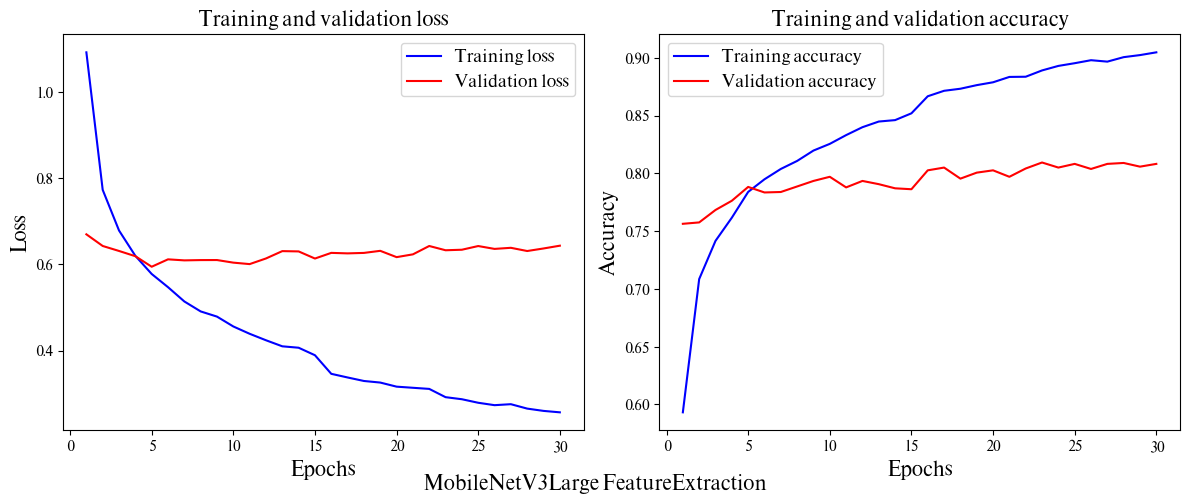

In [39]:
plot_history(history, save_path=ASSETS_FOR_MODEL_PATH, fontsize=14, title=f"{MODEL_NAME} {TYPE}")

### **Confusion Matrix**

In [47]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues,
                          save_path=None, fontsize=12):

    correct_predictions = np.trace(cm)
    total_samples = np.sum(cm)
    accuracy = correct_predictions / total_samples
    misclassification_rate = 1 - accuracy

    if title:
        if normalize:
            pic_title = f"{title}\nConfusion Matrix (normalized)"
        else:
            pic_title = f"{title}\nConfusion Matrix"
    else:
        if normalize:
            pic_title = "Confusion Matrix (normalized)"
        else:
            pic_title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(pic_title, fontsize=fontsize, ha="center")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=fontsize,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    metrics_text = (
        f"\nAccuracy: {accuracy:.4f}  |  Misclass: {misclassification_rate:.4f}"
    )
    plt.xlabel(f"Predicted label{metrics_text}", fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        if normalize:
            plt.savefig(f"{save_path}/confusion_matrix_normalized.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix_normalized.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/confusion_matrix.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix.svg", format="svg", bbox_inches="tight")

    plt.show()

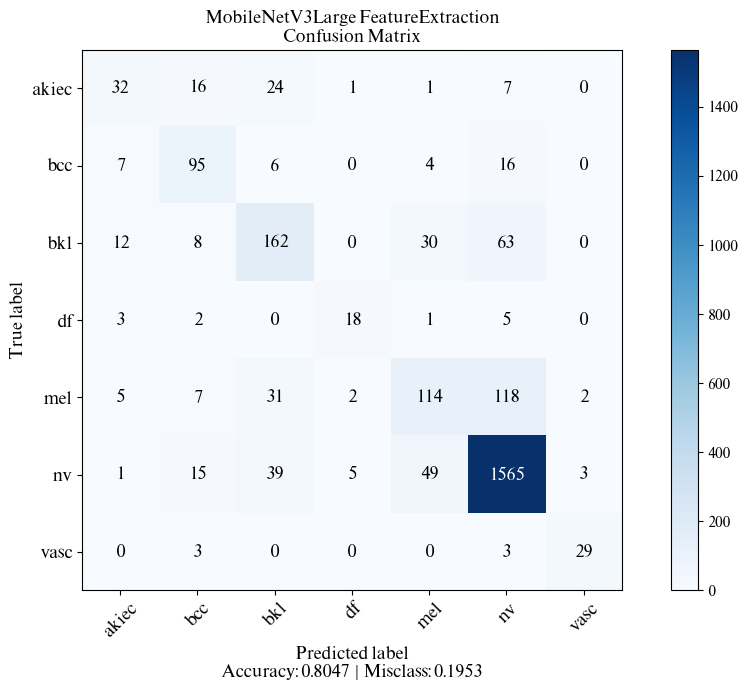

In [48]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=False, save_path=ASSETS_FOR_MODEL_PATH)

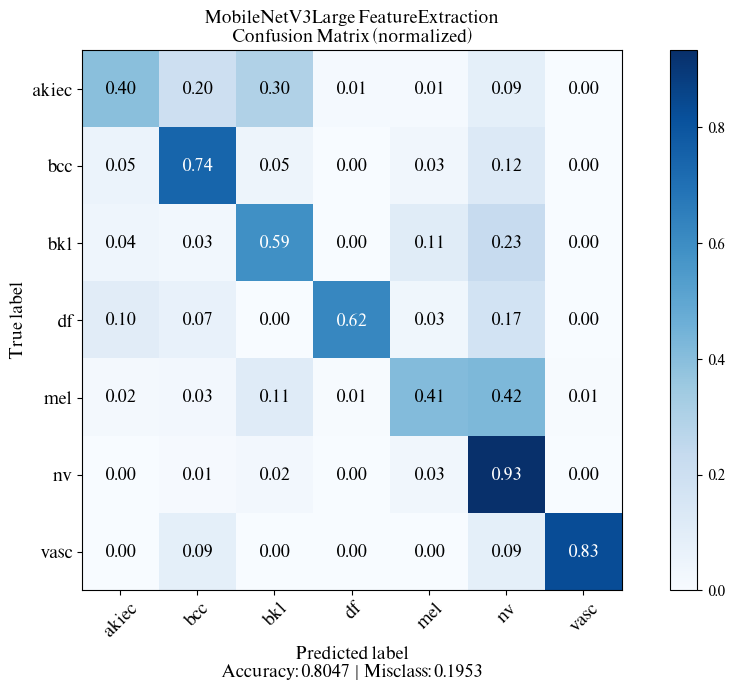

In [49]:
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=True, save_path=ASSETS_FOR_MODEL_PATH)

### **Plot AUC-ROC Curve**

In [50]:
def plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, title=None, save_path=None, fontsize=14):
    n_classes = y_pred_prob.shape[1]
    plt.figure(figsize=(12, 7))

    if title:
        pic_title = f"{title}\nReceiver Operating Characteristic (ROC) - Multiclass"
    else:
        pic_title = "Receiver Operating Characteristic (ROC) - Multiclass"

    for i in range(n_classes):
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color="deeppink", linestyle="--", lw=2,
             label=f"Micro-average (AUC = {roc_auc_micro:.4f})")

    roc_auc_macro = sklearn.metrics.roc_auc_score(y_true_onehot, y_pred_prob, average='macro')
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--",
             label=f"Macro-average (AUC = {roc_auc_macro:.4f})")

    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle=":")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(pic_title, fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=fontsize)
    plt.grid(alpha=0.3)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/roc_auc_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/roc_auc_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

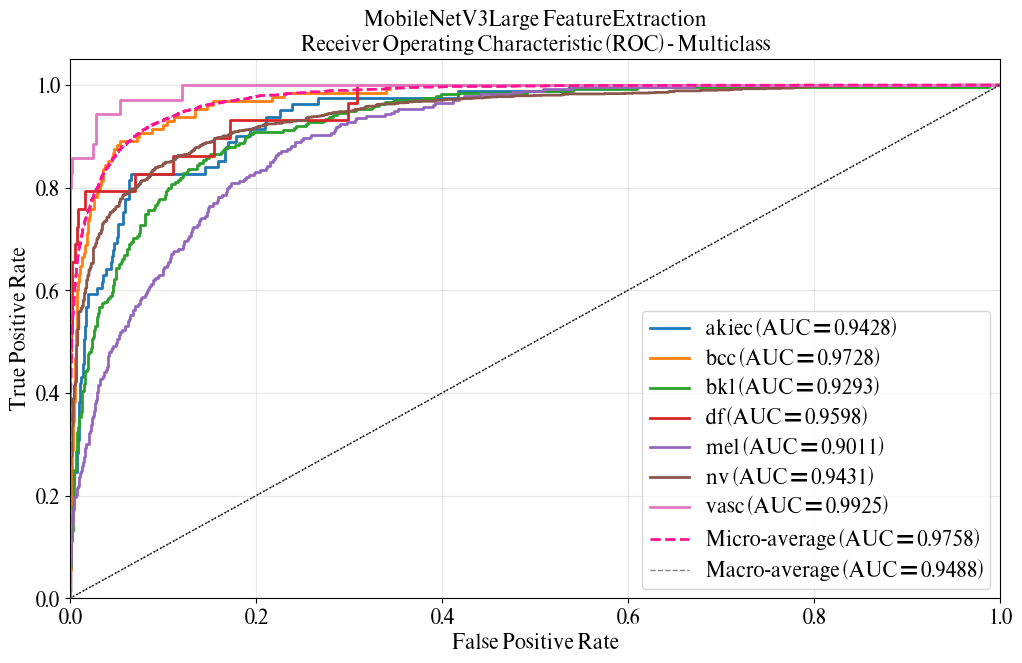

In [52]:
plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, f"{MODEL_NAME} {TYPE}", ASSETS_FOR_MODEL_PATH)